# KMC simulation of PLD with Deep Q Learning

In this versioin the state function is just the surface projection

In [1]:
!pip install keras

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install tensorflow-gpu

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import sys
import os
import numpy as np
import collections
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
target_roughness = 0.98 

In [5]:
#Writing some helper functions

def write_lattice_to_file(input_settings,position_vec, latt):
    #Write a new input lattice file
    #position_vec is the array containing positions of all of the atoms
    filename = input_settings['incfg_file'][0]
    new_latt_xyzs = list()
    
    for i in range(position_vec.shape[0]):
        new_latt_xyzs.append(list(['Ni', position_vec[i,0], position_vec[i,1],position_vec[i,2]]))

    new_latt = collections.OrderedDict()
    new_latt['nat'] = latt['nat']
    new_latt['box'] = latt['box']
    new_latt['xyzs'] = new_latt_xyzs

    write_latt(new_latt, filename)
    
    return 

def write_new_input_file(input_settings, filename):
    #Write a new input file, with settings laid out in the dictionary input_settings
    
    with open(filename, 'w') as fo:
        for key, val in input_settings.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)

def write_params_file(input_settings, new_parms):
    #IF you want to change parameters, use this function to write a new parameters file
    new_parms_file = input_settings['param_file']
    
    with open(new_parms_file, 'w') as fo:
        for key, val in new_parms.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)
            
def make_surface_proj(atom_box):
    #Given an atom box (matrix with 1s where atoms are), determine the surface projection
    
    surface_proj = np.zeros(shape=(atom_box.shape[0], atom_box.shape[1]))
    for i in range(surface_proj.shape[0]):
        for j in range(surface_proj.shape[1]):
            try:
                surface_proj[i,j] = np.max(np.where(atom_box[i,j,:]==1))
            except ValueError:
                surface_proj[i,j] = 0
    return surface_proj

def calc_roughness(surface_projection):
    #Calculate the roughness, given a surface projection
    N = surface_projection.shape[0]
    M = surface_projection.shape[1]
    zbar = np.mean(surface_projection)
    z_sum = 0
    for i in range(N):
        for j in range(M):
            z_sum+=((surface_projection[i,j] - zbar )**2)
    rms_roughness = np.sqrt((1.0/(N*M))*z_sum)
    return rms_roughness

def get_state_reward(sim_model):
    '''Given an input of the simulation model this function returns the state and reward'''
    #To get the final state put atoms into atom box
    arr = sim_model.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    reward = -1*np.sqrt((target_roughness-rms_val)**2) #penalty for straying from desired roughness.
    return surface_proj, reward

def run_sim_with_chosen_action(s,action,new_rates, verbose=False):
    #Given simulation model and the action, update the rate and continue running the simulation
    existing_rates = s.kmc.etree.rates
    
    new_updated_rates = get_incremented_rates(existing_rates, action, dep_rates)
    #[new_rates[action[0]], new_rates[action[1]], new_rates[action[2]]]
    #print('Old Rates are {} and New Rates are {}'.format(existing_rates, new_updated_rates))
    s.update_rate(np.array(new_updated_rates), verbose=verbose)
    
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99))
    
    #Now get the state and reward
    state, reward = get_state_reward(s)
            
    return state, reward, s,end_flag

def get_incremented_rates(existing_rates, action, dep_rates):
    #Given some rates and actions, increment appropriately and return updated rates
    new_rates=[]
    for ind, rate in enumerate(existing_rates):
        rate = max(rate+dep_rates[action[ind]],0.01)
        if rate>=0.30: rate = 0.3
        if rate <=0.10: rate = 0.10
        new_rates.append(rate)
    return new_rates
        

In [6]:
#Need to hold the state in memory and hten 

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
sys.path.append('..') #/Users/l2v/work/kmcsim

Import kmc simulation tools

In [9]:
from kmcsim.buildtools import make_fcc, write_latt
from kmcsim.sim import KMCModel
from kmcsim.sim import EventTree
from kmcsim.sim import RunSim

Working directory (inputs, outputs)

In [10]:
wdir = '../data/working'

In [11]:
#cat ../data/working/params

Set up simulation box and initial configuration of the substrate (with atoms filling the whole box)

In [12]:
# make substrate: perfect FCC lattice of given dimensions
box = [16, 32, 4]
latt = make_fcc(box)

In [13]:
# extend the box in the z-direction to make space for new layers to grow
latt['box'][3] = 12

In [14]:
# write initial configuration to xyz file in the working directory
write_latt(latt, os.path.join(wdir,'ni.xyz'))

In [15]:
sim = RunSim()
sim.read(os.path.join(wdir,'kmc.input'))
sim.init_sim()
sim.run()

time, iteration, number of atoms
(0.0, 0, 2048)
(5.001759991115094, 129, 2170)
(10.007900163159498, 249, 2270)
(15.058423180465079, 401, 2379)
(20.074573288002192, 556, 2485)
(25.089402601787544, 728, 2587)
(30.217888782382992, 906, 2697)
(35.242196190858806, 1119, 2838)
(40.24412642998915, 1339, 2983)
(45.27985274648659, 1540, 3110)
(50.30162450678955, 1754, 3249)
(55.31489234657202, 1971, 3378)
End of simulation
(60.00473252694996, 2143, 3479)


# Reinforcement Learning Trial

In [16]:
#Set up the neural network model. Input: atom position box. Output: 
#Choose out of 3  rates ([0.05, 0.1, 0.15]) for all three events. Vector of length 9.
from keras import Sequential
from keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Conv3D, MaxPool3D, Flatten
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, activation='relu', kernel_size = (3,3), strides = (1,1), batch_input_shape=(1,32,32,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, activation='relu', kernel_size = (3,3), strides = (1,1), batch_input_shape=(1,32,32,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, activation='relu', kernel_size = (3,3), strides = (1,1)))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.build()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (1, 30, 30, 32)           320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 15, 15, 32)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 13, 13, 64)           18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (1, 6, 6, 64)             0         
_________________________________________________________________
conv2d_3 (Conv2D)            (1, 4, 4, 32)             18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (1, 2, 2, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (1, 128)                  0         
__________

In [17]:
num_episodes = 150
y = 0.50
eps = 0.8
decay_factor = 0.992
r_avg_list = []
dep_rates = [-0.02, 0.00, 0.02] #decrease existing rate, maintain, or increase. For all three.
action_chosen = []

s = RunSim()
s.read(os.path.join(wdir,'kmc.input')) #Initialize the simulation with this input

for episode in range(num_episodes):
    t0 = time()
    if episode%10==0:
        print('Episode No. {}'.format(episode))
        
    counter = 0
    r_sum = 0
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    
    s.init_sim()
    s.update_rate(np.array([np.random.randint(low=1, high = 3)*0.03,
                           np.random.randint(low=1, high = 3)*0.03,
                           np.random.randint(low=1, high = 2)*0.03]), verbose=True)
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99)) #Run the simulation from the initial conditions
    
    while end_flag!=1:
        
        eps *= decay_factor
        #eps = max(eps, 0.05) #maintain some semblence of exploration ;)
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        if np.random.random() < eps:
            action = [np.random.randint(0, 3), np.random.randint(0, 3), np.random.randint(0, 3)]
            #Need to choose three actions at the same time.
        else:
            action = [np.argmax(model.predict(state[None,:,:,None])[0][:3]),
                      np.argmax(model.predict(state[None,:,:,None])[0][3:6]),
                      np.argmax(model.predict(state[None,:,:,None])[0][6:])]
            
        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        old_rates = s.kmc.etree.rates
        s_new, reward_new, kmc_model, end_flag = run_sim_with_chosen_action(s,action, dep_rates)
        
        reward_new = -1 #Make it all or nothing. If sim is ended, then get roughness to check on closeness to target.
        
        target = reward_new + y * np.max(model.predict(s_new[None,:,:,None]))
        target_vec = model.predict(state[None,:,:,None])[0]
        target_vec[action] = target
        
        #print("Action Number: {}, Deposition Rate: {}".format(counter, dep_rates[action]))
        
        model.fit(state[None,:,:,None], target_vec.reshape(-1, 9), epochs=1, verbose=0)
        s = kmc_model
        counter+=1
        #r_sum.append(reward_new)
        
        action_chosen.append(action)
        
    arr = s.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    
    if np.abs(rms_val - target_roughness)<0.05: reward_new = 1000
    else: reward_new = -1
        
    target = reward_new + y * np.max(model.predict(s_new[None,:,:,None]))
    target_vec = model.predict(state[None,:,:,None])[0]
    target_vec[action] = target

    #print("Action Number: {}, Deposition Rate: {}".format(counter, dep_rates[action]))

    model.fit(state[None,:,:,None], target_vec.reshape(-1, 9), epochs=1, verbose=0)
    
    t1 = time()    
    print("Took {} s and reward was {}".format(np.round(t1-t0, 4), reward_new))
        
    r_avg_list.append(reward_new)


Episode No. 0
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 26.581 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 20.4238 s and reward was -1
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.03 0.03]
('kmc step:', 0)
Took 20.9079 s and reward was -1
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 24.1591 s and reward was -1
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.03 0.03]
('kmc step:', 0)
Took 22.1136 s and reward was -1
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 19.6959 s and reward was -1
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.06 0.03]
('kmc step:', 0)
Took 20.1605 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 19.3803 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 24.4948 s and reward was -1


Took 18.2045 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.03 0.03]
('kmc step:', 0)
Took 19.3426 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 18.4416 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 17.9643 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 19.1383 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.03 0.03]
('kmc step:', 0)
Took 17.8249 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.03 0.03]
('kmc step:', 0)
Took 18.6052 s and reward was 1000
Episode No. 80
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.06 0.03]
('kmc step:', 0)
Took 19.8042 s and reward was -1
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.03 0.03]
('kmc step:', 0)
Took 19.8722 s and reward was -1
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.03 0.03]
('kmc s

Took 19.3415 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.06 0.03]
('kmc step:', 0)
Took 17.7157 s and reward was 1000
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.03 0.03]
('kmc step:', 0)
Took 19.6426 s and reward was 1000


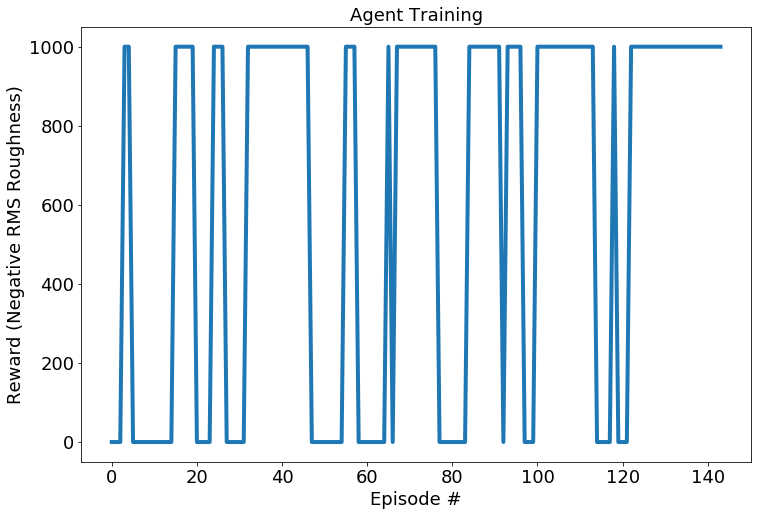

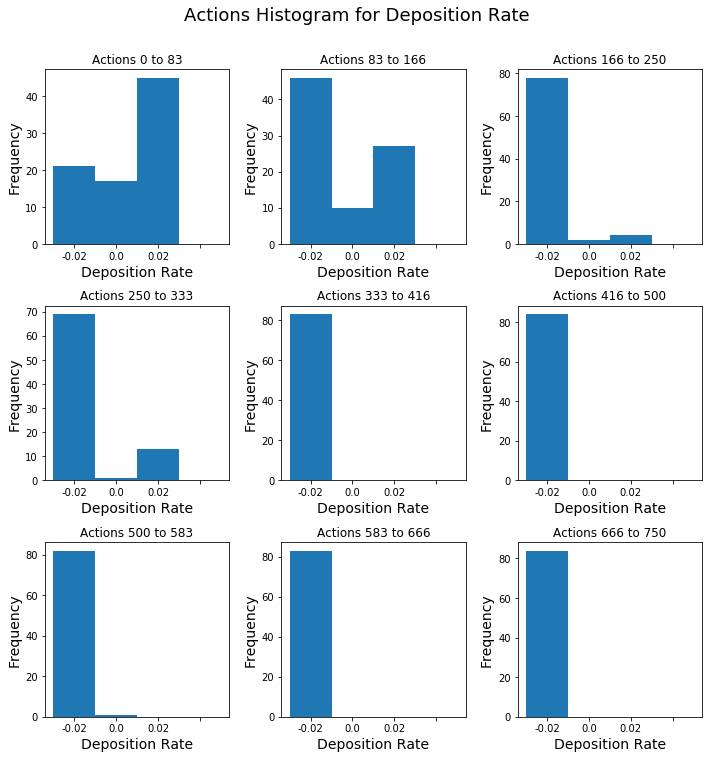

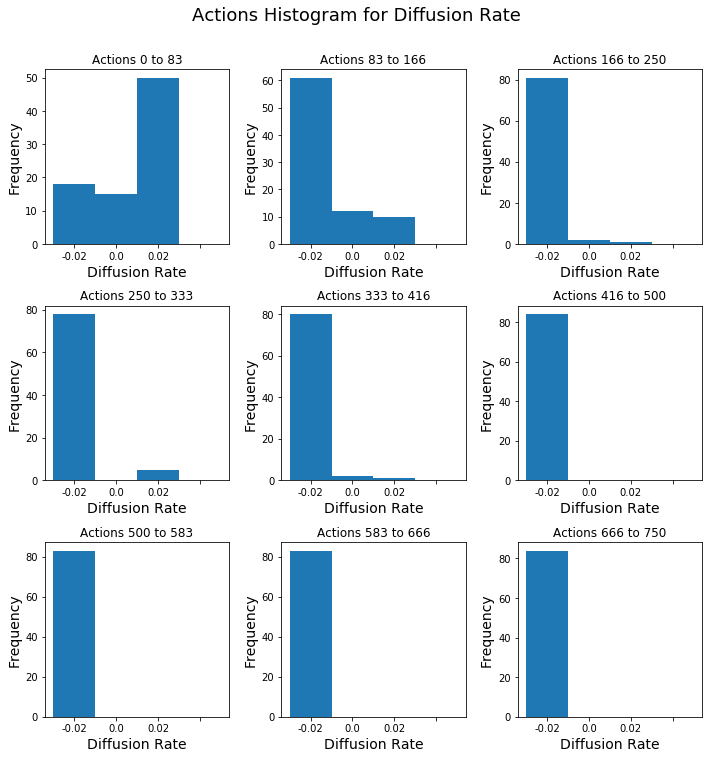

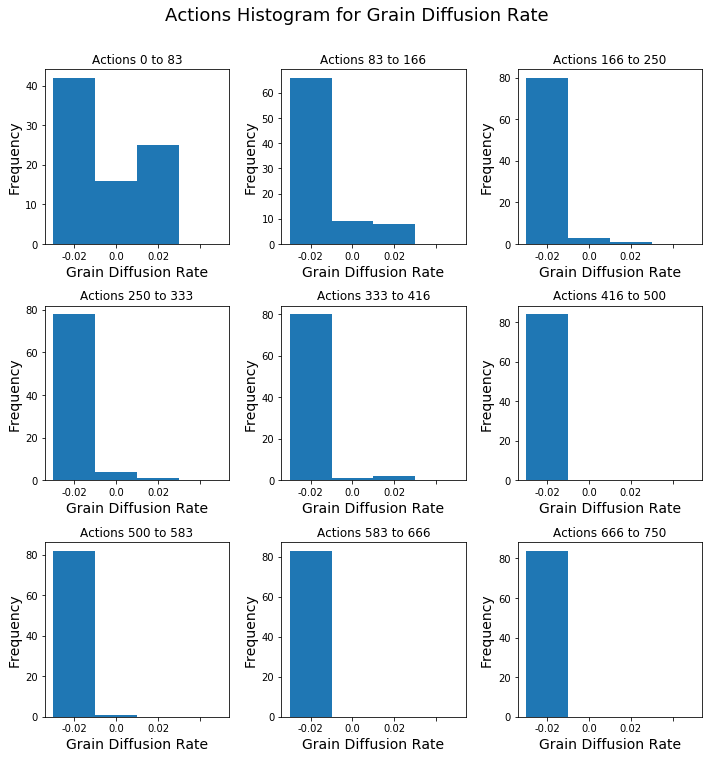

In [18]:
r_avg_list = np.array(r_avg_list).ravel()
from scipy.signal import wiener, medfilt

kernel_size = 1

plt.figure(figsize = (12,8))
plt.plot(medfilt(r_avg_list, kernel_size= kernel_size)[kernel_size:-kernel_size], linewidth = 4)
plt.title('Agent Training', fontsize = 18)
plt.xlabel('Episode #', fontsize = 18)
plt.ylabel('Reward (Negative RMS Roughness)', fontsize = 18)
plt.xticks(fontsize =18)
plt.yticks(fontsize =18)
plt.savefig('reward_per_episode_dep_sp.png', dpi = 300)

#Let's take a look at how the actions change over time: consider 9 increments

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

rate_labels = ['Deposition Rate', 'Diffusion Rate', 'Grain Diffusion Rate']

for i in range(3):
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
    for ind, ax in enumerate(axes.flat):
        seg_start = int(segments[ind])
        seg_finish = min(int(segments[ind+1]),total_actions)
        act_segment = np.array(action_chosen[seg_start:seg_finish])[:,i] 
       
        ax.hist(act_segment, bins = [0,1,2,3,4])
        ax.set_xlabel(rate_labels[i], fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(dep_rates)

    fig.suptitle('Actions Histogram for ' + rate_labels[i], fontsize = 18, y = 1.05)
    fig.tight_layout()
    fig.savefig('actions_histogram_dep_sp_'+str(i) +'.png', dpi = 300)

# Policy Evaluation

In [19]:
#Let's see what the roughness actually is for the policy
num_episodes = 20
r_avg_list = []
action_chosen = []

for episode in range(num_episodes):
    t0 = time()
    if episode%5==0:
        print('Episode No. {}'.format(episode))
        
    counter = 0
    r_sum = []
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    
    s.init_sim()
    
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99)) #Run the simulation from the initial conditions
    
    while end_flag!=1:
        
        eps *= decay_factor
        #eps = max(eps, 0.05) #maintain some semblence of exploration ;)
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        
        action = [np.argmax(model.predict(state[None,:,:,None])[0][:3]),
                  np.argmax(model.predict(state[None,:,:,None])[0][3:6]),
                  np.argmax(model.predict(state[None,:,:,None])[0][6:])]
            
        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        old_rates = s.kmc.etree.rates
        s_new, reward_new, kmc_model, end_flag = run_sim_with_chosen_action(s,action, dep_rates)

        s = kmc_model
        counter+=1
        r_sum.append(reward_new)
        
        action_chosen.append(action)
    t1 = time()    
    print("Took {} s".format(np.round(t1-t0, 4)))
    
    arr = s.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    r_avg_list.append(rms_val)

Episode No. 0
Took 19.4613 s
Took 19.1309 s
Took 19.2675 s
Took 19.4716 s
Took 19.4391 s
Episode No. 5
Took 19.5717 s
Took 19.4649 s
Took 19.0189 s
Took 19.9637 s
Took 19.3898 s
Episode No. 10
Took 19.2177 s
Took 19.6012 s
Took 18.2725 s
Took 17.8948 s
Took 18.9069 s
Episode No. 15
Took 18.7746 s
Took 18.5352 s
Took 18.2578 s
Took 18.347 s
Took 19.2588 s


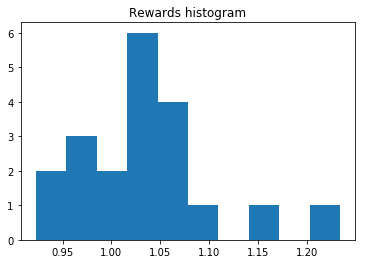

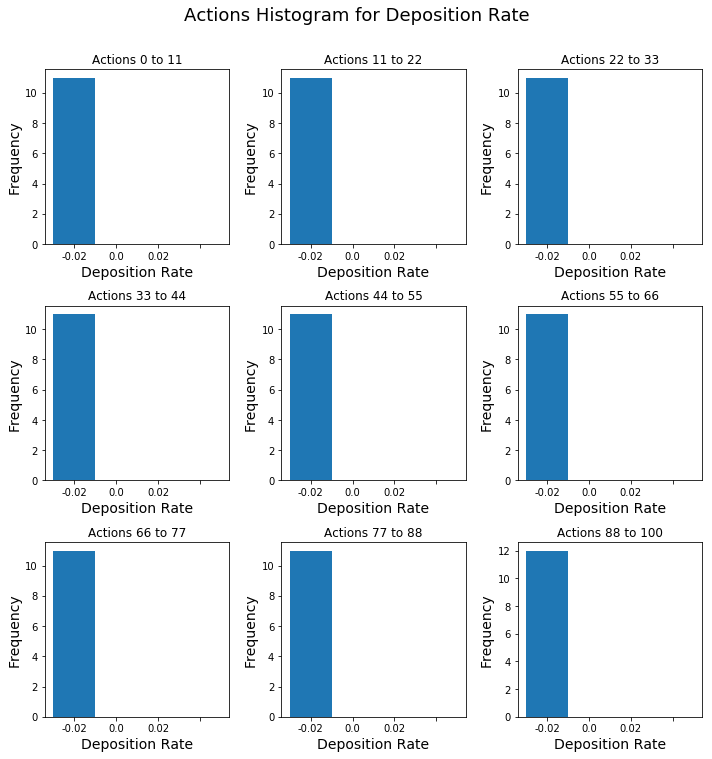

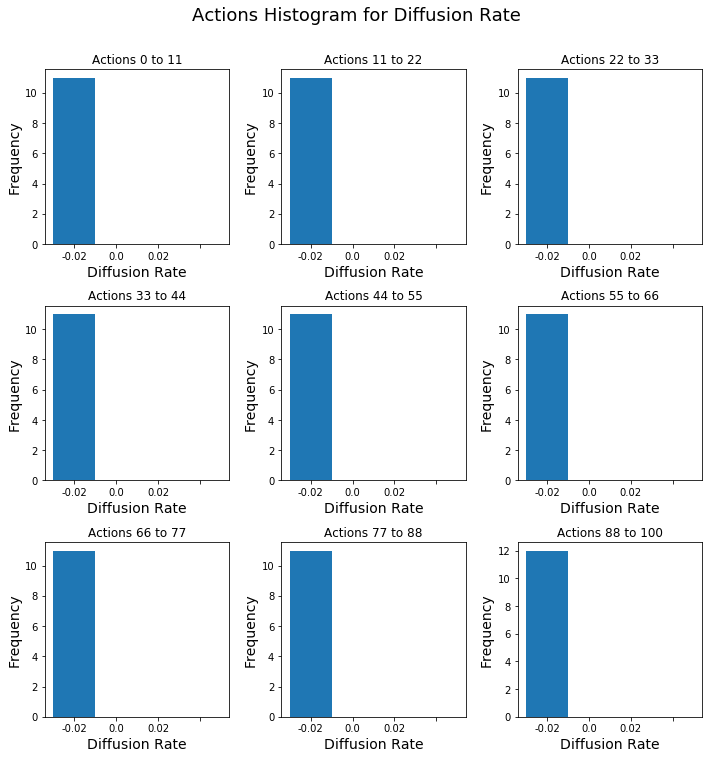

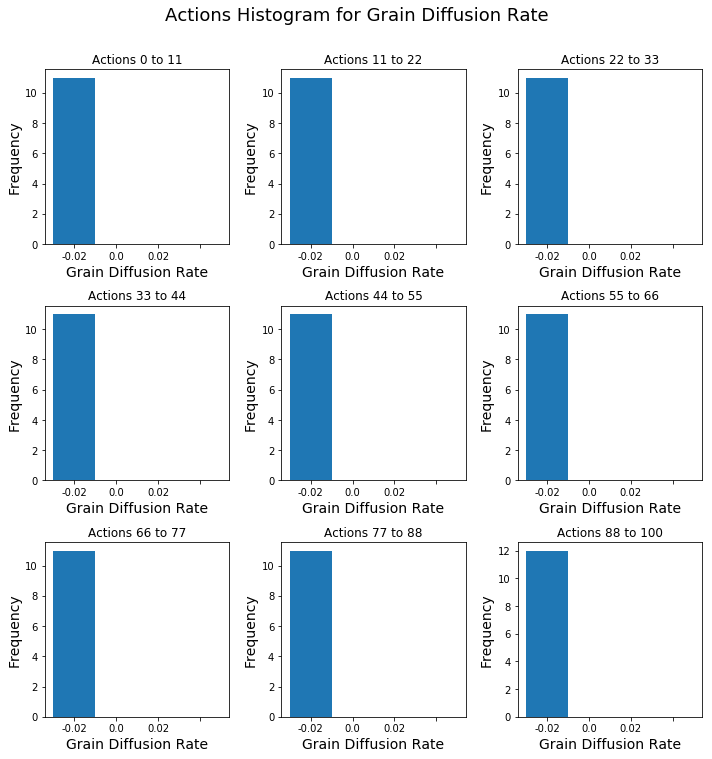

In [20]:
r = np.array(r_avg_list)
plt.figure()
plt.hist(r.ravel())
plt.title('Rewards histogram')

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

for i in range(3):
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
    for ind, ax in enumerate(axes.flat):
        seg_start = int(segments[ind])
        seg_finish = min(int(segments[ind+1]),total_actions)
        act_segment = np.array(action_chosen[seg_start:seg_finish])[:,i] 
       
        ax.hist(act_segment, bins = [0,1,2,3,4])
        ax.set_xlabel(rate_labels[i], fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(dep_rates)

    fig.suptitle('Actions Histogram for ' + rate_labels[i], fontsize = 18, y = 1.05)
    fig.tight_layout()

# Robustness to initial conditions

In [23]:
#Let's see what the roughness actually is for the policy
num_episodes = 20
r_avg_list = []
action_chosen = []

for episode in range(num_episodes):
    t0 = time()
    if episode%5==0:
        print('Episode No. {}'.format(episode))
        
    counter = 0
    r_sum = []
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    
    s.init_sim()
    s.update_rate(np.array([np.random.randint(low=1, high = 6)*0.03,
                           np.random.randint(low=1, high = 6)*0.03,
                           np.random.randint(low=1, high = 4)*0.03]), verbose=True)
    
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99)) #Run the simulation from the initial conditions
    
    while end_flag!=1:
        
        eps *= decay_factor
        #eps = max(eps, 0.05) #maintain some semblence of exploration ;)
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        
        action = [np.argmax(model.predict(state[None,:,:,None])[0][:3]),
                  np.argmax(model.predict(state[None,:,:,None])[0][3:6]),
                  np.argmax(model.predict(state[None,:,:,None])[0][6:])]
            
        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        old_rates = s.kmc.etree.rates
        s_new, reward_new, kmc_model, end_flag = run_sim_with_chosen_action(s,action, dep_rates)

        s = kmc_model
        counter+=1
        r_sum.append(reward_new)
        
        action_chosen.append(action)
    t1 = time()    
    print("Took {} s".format(np.round(t1-t0, 4)))
    
    arr = s.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    r_avg_list.append(rms_val)

Episode No. 0
current rates:[0.05 0.05 0.01] 
new rates:[0.09 0.15 0.03]
('kmc step:', 0)
Took 21.6163 s
current rates:[0.05 0.05 0.01] 
new rates:[0.15 0.09 0.06]
('kmc step:', 0)
Took 29.3026 s
current rates:[0.05 0.05 0.01] 
new rates:[0.15 0.09 0.03]
('kmc step:', 0)
Took 27.5636 s
current rates:[0.05 0.05 0.01] 
new rates:[0.12 0.15 0.09]
('kmc step:', 0)
Took 23.6781 s
current rates:[0.05 0.05 0.01] 
new rates:[0.09 0.06 0.09]
('kmc step:', 0)
Took 21.062 s
Episode No. 5
current rates:[0.05 0.05 0.01] 
new rates:[0.15 0.03 0.06]
('kmc step:', 0)
Took 27.3808 s
current rates:[0.05 0.05 0.01] 
new rates:[0.03 0.12 0.09]
('kmc step:', 0)
Took 19.2395 s
current rates:[0.05 0.05 0.01] 
new rates:[0.12 0.12 0.06]
('kmc step:', 0)
Took 23.4216 s
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.09 0.03]
('kmc step:', 0)
Took 19.9222 s
current rates:[0.05 0.05 0.01] 
new rates:[0.06 0.15 0.03]
('kmc step:', 0)
Took 19.8875 s
Episode No. 10
current rates:[0.05 0.05 0.01] 
new rates:[0.06 

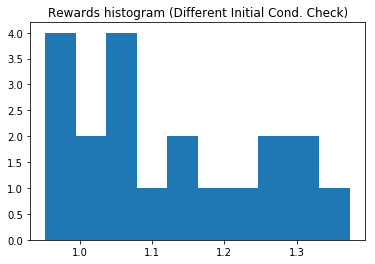

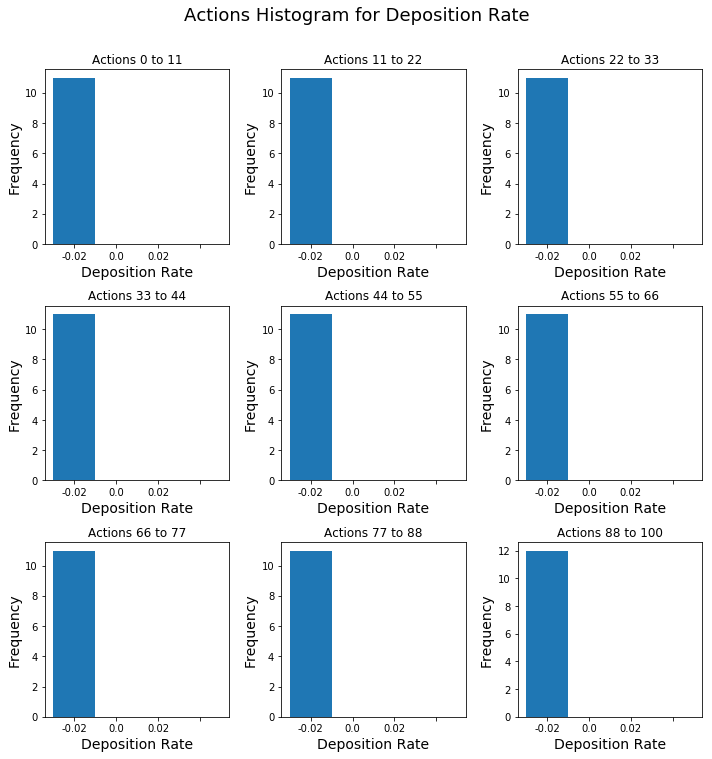

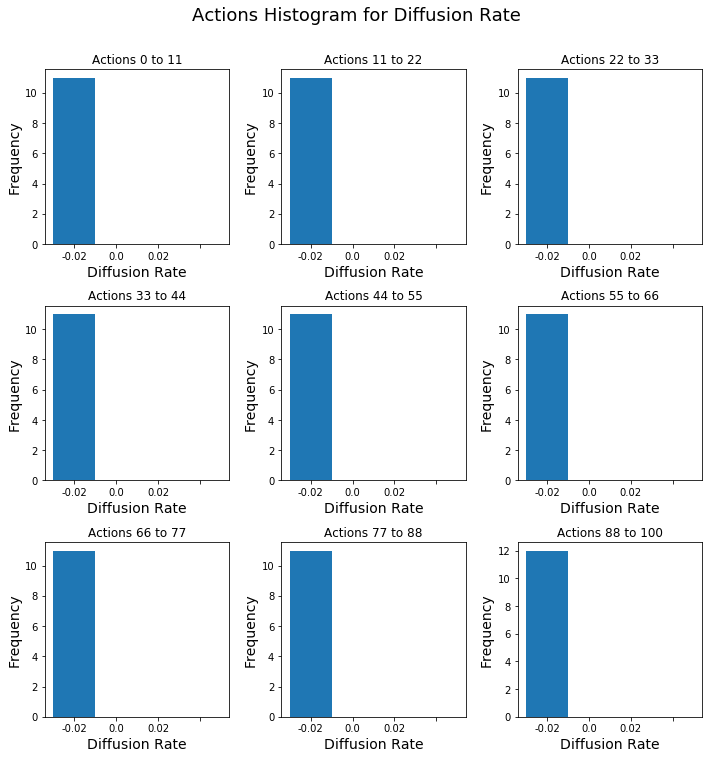

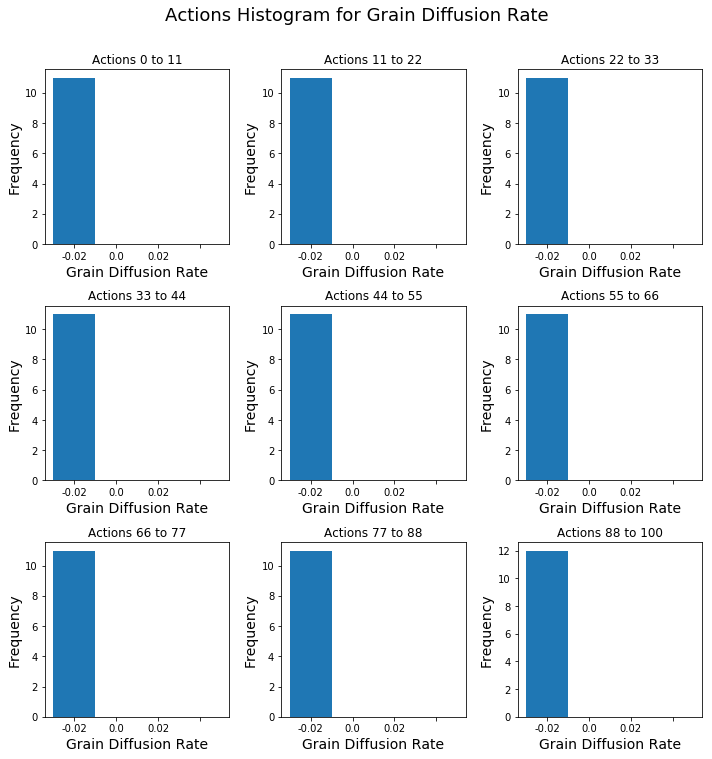

In [24]:
r = np.array(r_avg_list)
plt.figure()
plt.hist(r.ravel())
plt.title('Rewards histogram (Different Initial Cond. Check)')

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

for i in range(3):
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
    for ind, ax in enumerate(axes.flat):
        seg_start = int(segments[ind])
        seg_finish = min(int(segments[ind+1]),total_actions)
        act_segment = np.array(action_chosen[seg_start:seg_finish])[:,i] 
       
        ax.hist(act_segment, bins = [0,1,2,3,4])
        ax.set_xlabel(rate_labels[i], fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(dep_rates)

    fig.suptitle('Actions Histogram for ' + rate_labels[i], fontsize = 18, y = 1.05)
    fig.tight_layout()

In [21]:
# Compare with Random policy
#Let's see what the roughness actually is for the policy
num_episodes = 20
r_avg_list = []
action_chosen = []

for episode in range(num_episodes):
    t0 = time()
    if episode%5==0:
        print('Episode No. {}'.format(episode))
        
    counter = 0
    r_sum = []
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    
    s.init_sim()
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99)) #Run the simulation from the initial conditions
    
    while end_flag!=1:
        
        
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        
        action = [np.random.randint(0, 3), np.random.randint(0, 3), np.random.randint(0, 3)]
            
        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        old_rates = s.kmc.etree.rates
        s_new, reward_new, kmc_model, end_flag = run_sim_with_chosen_action(s,action, dep_rates)

        s = kmc_model
        counter+=1
        r_sum.append(reward_new)
        
        action_chosen.append(action)
    t1 = time()    
    print("Took {} s".format(np.round(t1-t0, 4)))
        
    arr = s.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    r_avg_list.append(rms_val)

Episode No. 0
Took 18.8406 s
Took 21.6212 s
Took 20.4243 s
Took 20.216 s
Took 21.3491 s
Episode No. 5
Took 19.9647 s
Took 21.1774 s
Took 21.5465 s
Took 20.0209 s
Took 23.4783 s
Episode No. 10
Took 22.8815 s
Took 20.6 s
Took 20.0466 s
Took 20.2285 s
Took 18.9224 s
Episode No. 15
Took 21.2358 s
Took 18.9834 s
Took 20.9087 s
Took 20.7588 s
Took 19.891 s


In [ ]:
r = np.array(r_avg_list)
plt.figure()
plt.hist(r.ravel())
plt.title('Rewards histogram')

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

for i in range(3):
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
    for ind, ax in enumerate(axes.flat):
        seg_start = int(segments[ind])
        seg_finish = min(int(segments[ind+1]),total_actions)
        act_segment = np.array(action_chosen[seg_start:seg_finish])[:,i] 
       
        ax.hist(act_segment, bins = [0,1,2,3,4])
        ax.set_xlabel(rate_labels[i], fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(dep_rates)

    fig.suptitle('Actions Histogram for ' + rate_labels[i], fontsize = 18, y = 1.05)
    fig.tight_layout()

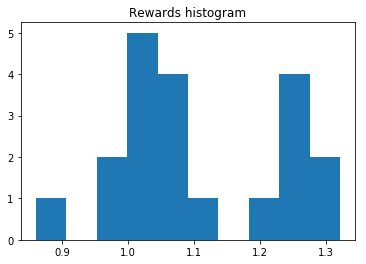

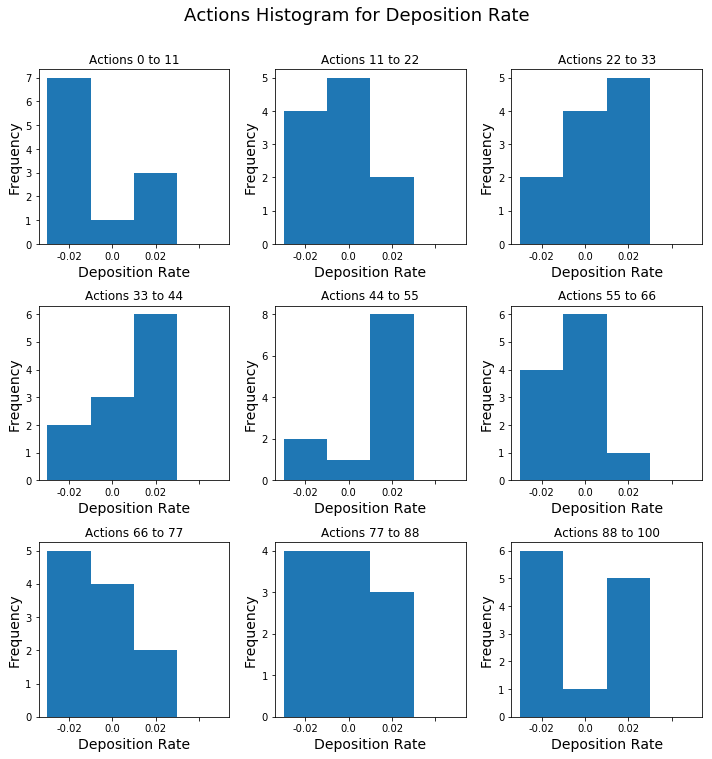

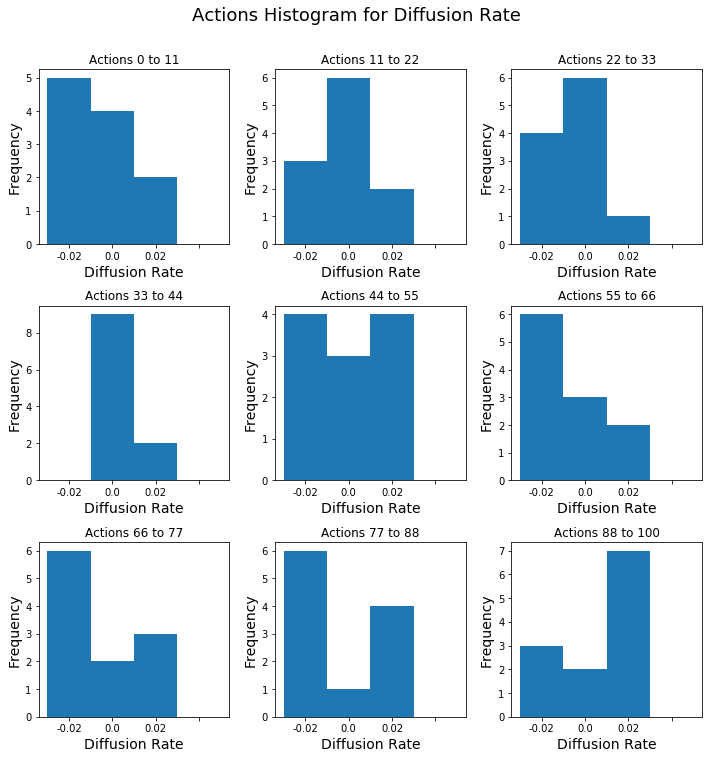

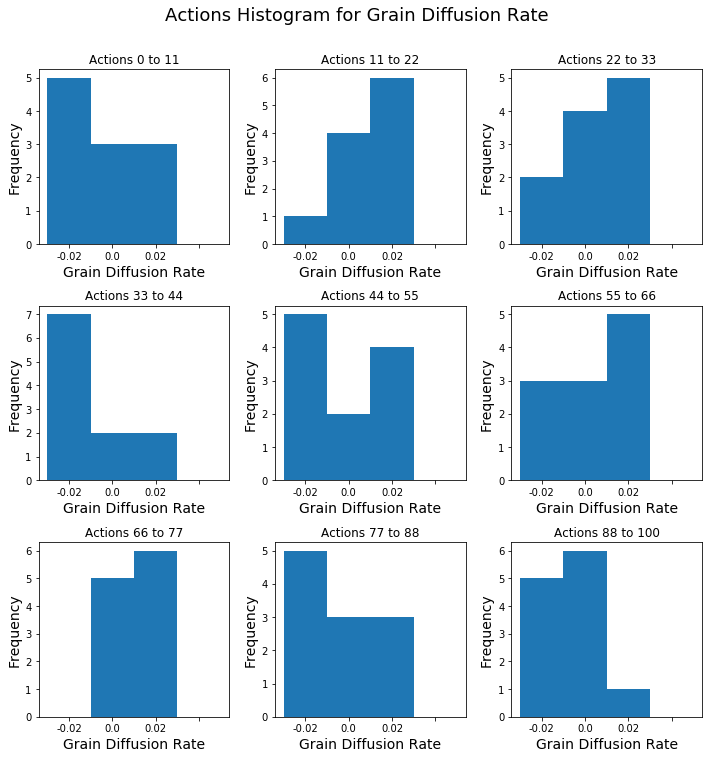

In [22]:
r = np.array(r_avg_list)
plt.figure()
plt.hist(r.ravel())
plt.title('Rewards histogram')

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

for i in range(3):
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
    for ind, ax in enumerate(axes.flat):
        seg_start = int(segments[ind])
        seg_finish = min(int(segments[ind+1]),total_actions)
        act_segment = np.array(action_chosen[seg_start:seg_finish])[:,i] 
       
        ax.hist(act_segment, bins = [0,1,2,3,4])
        ax.set_xlabel(rate_labels[i], fontsize = 14)
        ax.set_ylabel('Frequency', fontsize = 14)
        ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(dep_rates)

    fig.suptitle('Actions Histogram for ' + rate_labels[i], fontsize = 18, y = 1.05)
    fig.tight_layout()